In [2]:
# Import neededs libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# The first thing to do is to load the data file as data frame with pandas library
dff = pd.read_csv("dataFile.csv")

# Show the first rows (5 by default) of the data set
dff.head()

# Set a copy of dataframe to avoid lodding data set more than one time
df = dff

## Exploring and cleaning the data

In [4]:
# To get information of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 13 columns):
ID                      500000 non-null int64
credit_used             500000 non-null int64
limit_allowed           500000 non-null int64
credit_score            491910 non-null float64
nb_days_account_open    499962 non-null float64
interests               499135 non-null float64
loyalty                 499135 non-null float64
card_change             500000 non-null int64
age                     493504 non-null float64
nb_costumers            500000 non-null int64
reward                  499971 non-null object
card_name               500000 non-null object
insurance               500000 non-null object
dtypes: float64(5), int64(5), object(3)
memory usage: 49.6+ MB


In [5]:
# Description of the non-categorial feautures
df.describe()

,ID,credit_used,limit_allowed,credit_score,nb_days_account_open,interests,loyalty,card_change,age,nb_costumers
count,500000.000000,500000.000000,500000.000000,491910.000000,499962.000000,499135.000000,4.991350e+05,500000.000000,493504.000000,500000.000000
mean,250000.500000,1870.360810,7532.450354,1523.960228,3972.884655,0.378791,9.239990e+03,0.435724,49.719790,1.111524
std,144337.711635,3354.169502,6408.509340,121.928750,3635.144968,0.879736,3.459390e+04,0.495852,17.314401,0.348348
min,1.000000,-184880.000000,0.000000,0.000000,25.000000,-0.017000,-6.519000e+04,0.000000,2.000000,0.000000
25%,125000.750000,10.000000,2750.000000,1458.000000,980.000000,0.000000,0.000000e+00,0.000000,36.000000,1.000000
50%,250000.500000,491.000000,6000.000000,1548.000000,2760.000000,0.000000,5.900000e+02,0.000000,51.000000,1.000000
75%,375000.250000,2185.000000,10750.000000,1610.000000,5993.000000,0.284000,3.668000e+03,1.000000,63.000000,1.000000
max,500000.000000,115166.000000,350000.000000,1776.000000,16196.000000,27.982000,3.245674e+06,1.000000,675.000000,6.000000


In [6]:
# Check if there are missing values. 'True' means that the column has missing values.
print(df.isnull().any())

ID                      False
credit_used             False
limit_allowed           False
credit_score             True
nb_days_account_open     True
interests                True
loyalty                  True
card_change             False
age                      True
nb_costumers            False
reward                   True
card_name               False
insurance               False
dtype: bool


## Generating usable features

In [7]:
# To eastimate the length of data without missing values, we should make conditions on features:
cond1 = df.credit_score.notnull()
cond2 = df.nb_days_account_open.notnull()
cond3 = df.interests.notnull()
cond4 = df.loyalty.notnull()
cond5 = df.age.notnull()
cond6 = df.card_change.notnull()
cond7 = df.reward.notnull()

# 'distinct_names' is the number of costumers for each account. It should > 0
cond8 = df.nb_costumers > 0

# 'credit_limit' is limite of credit allowed to each costumer. It should > 0
cond9 = df.limit_allowed > 0

# We see that the maximum of 'age' is 675. We'll considere only values less than 100.
cond10 = df.age <= 100

# Show the part of data with completed columns
print(100 * len(df[cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9 & cond10]) /len(df), '%')

97.0912 %


In [8]:
# The missing values part of data set is less than 3%. So let's discard it and create dataframe without missing values

df = df[cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9 & cond10]
# drop ID column
df = df.drop(['ID'], axis=1)
print(df.isnull().any())

credit_used             False
limit_allowed           False
credit_score            False
nb_days_account_open    False
interests               False
loyalty                 False
card_change             False
age                     False
nb_costumers            False
reward                  False
card_name               False
insurance               False
dtype: bool


In [9]:
# The last column is the target. In order to classifier the data set with customers who has insurance 
# and those who hasen't, we should do the following mapping:
# 'No' ---> 0
# 'Classic' and 'Privilege Plus' ----> 1

mapping = {'No': 0, 'Classic': 1, 'Privilege Plus': 1}
df = df.replace({'insurance': mapping})

df.head()

,credit_used,limit_allowed,credit_score,nb_days_account_open,interests,loyalty,card_change,age,nb_costumers,reward,card_name,insurance
0,0,10000,1442.0,435.0,0.000,0.0,0,46.0,1,X,Primum,1
1,4689,15000,1478.0,3953.0,0.000,32254.0,1,36.0,2,M2,Liberety,0
2,2532,7000,1540.0,4616.0,1.001,2479.0,1,48.0,1,M2,Golde one,1
3,170,12000,1582.0,2263.0,0.000,0.0,0,57.0,2,Z,Force task,1
4,378,22000,1350.0,5837.0,0.000,9721.0,0,53.0,1,M2,Health,0


# Visualisation

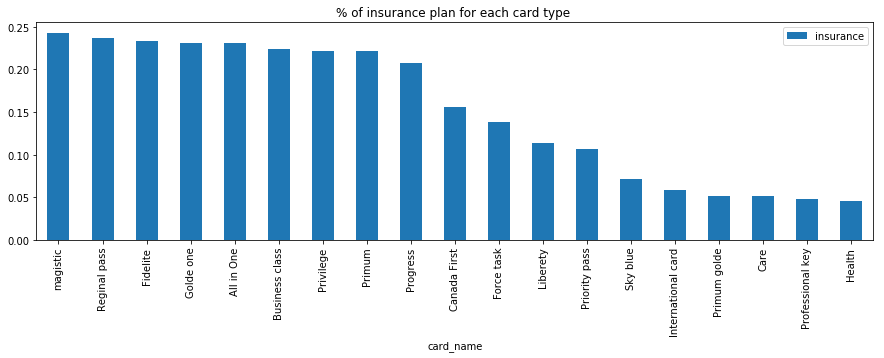

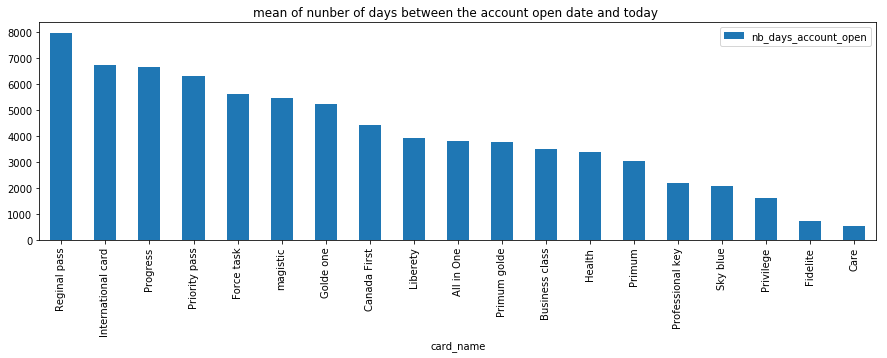

In [10]:
# Show the distribution of the insurance plan according to the type of card
df_Visual=df[['card_name','insurance']].groupby(['card_name']).mean()
df_Visual=df_Visual.sort_values('insurance',ascending=False)

df_Visual.plot(kind='bar', figsize=(15, 4)).set_title('% of insurance plan for each card type ')
plt.show()

# Show the distribution of the number of the days between the account open date and today 
# according to the type of card
df_Visual0=df[['card_name','nb_days_account_open']].groupby(['card_name']).mean()
df_Visual0=df_Visual0.sort_values('nb_days_account_open',ascending=False)


df_Visual0.plot(kind='bar', figsize=(15, 4)).set_title('mean of nunber of days between the account open date and today ')
plt.show()

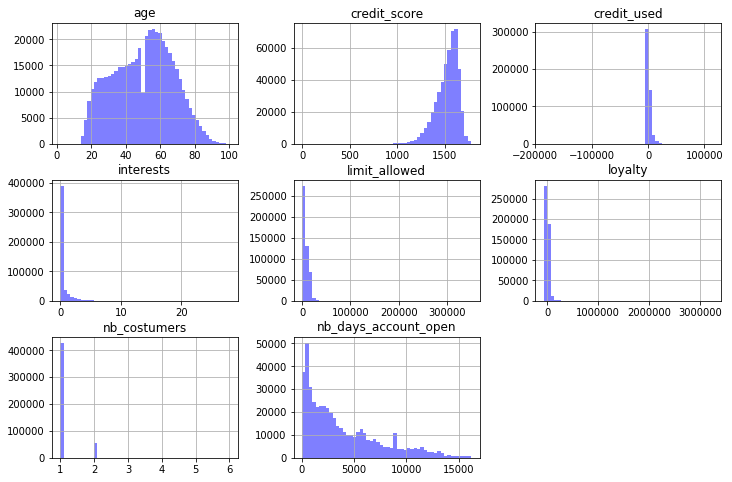

In [11]:
# Show the distribution of each non-categorial feature
temp_df = df[['credit_used', 'limit_allowed', 'credit_score', 'nb_days_account_open', 'interests', 'loyalty', 'age', 'nb_costumers']]
temp_df.hist(bins=50, color='b',figsize=(12,8), alpha=0.5)
plt.show()

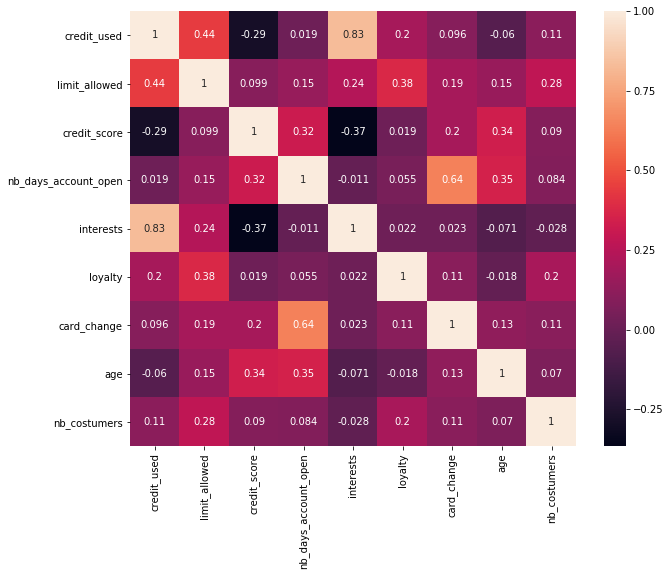

In [12]:
# Find correlations between non-categorial features ( from column 'credit_used' to column 'nb_costumers')
temp_df=df.iloc[:,:-3]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)


We see first the importante coorelation between:

- 'credit_used' and ('interests'(0.83), 'limit_allowed' (0.44), 'credit_score' (-0.29))
- 'limit_allowed' and ('loyalty' (0.38), 'nb_costumers' (0.28), 'interests' (0.24))
- 'credit_score' and ('interests' (-0.37), 'card_change' (0.33), 'nb_days_account_open' (0.32))
- 'nb_days_account_open' and ('age' (0.64), 'card_change' (0.35)).

So we can choose three features from this columns as:
- feature1 = 'credit_used' / 'limit_allowed'
- feature2 = 'credit_score'
- feature3 = 'age'

The label still 'insurance'
- label = 'insurance'

## Models, train set and test set

The naive way to handel this data is to reduce the number of featutres and to apply differentes models.first, we'll use only three.

In [13]:
# lets create a new data frame with less numbers of features (non-correlated) and label:
df1 = pd.DataFrame()
df1['feature1'] = df['credit_used'] / df['limit_allowed'] 
df1['feature2'] = df['credit_score']
df1['feature3'] = df['age']

df1['insurance'] = df['insurance']
df1.head()

,feature1,feature2,feature3,insurance
0,0.000000,1442.0,46.0,1
1,0.312600,1478.0,36.0,0
2,0.361714,1540.0,48.0,1
3,0.014167,1582.0,57.0,1
4,0.017182,1350.0,53.0,0


In [14]:
col = ['feature1', 'feature2', 'feature3']

ya = np.array(df1['insurance'])
xa = preprocessing.normalize(df1[col])


x_train, x_test, y_train, y_test = train_test_split(xa, ya, test_size=0.33, random_state=42)

We should check the precision for every model.
The tools for that are : confusion matrix and accuracy of the model, precision, recall and F1-score for each class.


 <table style="width:30%">
  <tr>
    <th></th>
    <th>Predicted class</th>
    <th></th>
  </tr>
  <tr>
    <td>True class</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>0</td>
    <td>TP</td>
    <td>FN</td>
  </tr>
  <tr>
    <td>1</td>
    <td>FP</td>
    <td>TN</td>
  </tr>
</table> 
     
     
Class 0:
- $recall_0    = \frac{TP}{TP + FN}$
- $precision_0 = \frac{TP}{TP + FP}$
- $F1_0        = \frac{2}{ \frac{1}{recall_0} + \frac{1}{precision_0} }$
                 
Class 1:
- $recall_1    = \frac{TN}{TN + FP}$
- $precision_1 = \frac{TN}{TN + FN}$
- $F1_1        = \frac{2}{ \frac{1}{recall_1} + \frac{1}{precision_1} }$
                  
$accuracy = \frac{TP + TN}{TP + FP + TN + FN}$
                 
The recall measures the ability of a test to find all the relevant cases within a dataset for each class.
The precision measures the probability that each prediction is correcte. It expresses the proportion of the data points our model says was relevant actually were relevant.
This two parameters should be great enough to describe a good model. This is done by the function f1-score.

For unbalanced data, F1 of each class becomes as important as the accuracy. 

For this data set, we shoose many models. To compare them, we'll use confusion-matrix:

Here, we use a prototype model to get accuracy score for both tain and test data set. The classification report provides values of precision, recall and f1-score for each class.

In [15]:
def model(clf, name, x_train, y_train, x_test, y_test):
    
    clf.fit(x_train, y_train)
    
    print('=========================================================')
    
    # test prediction
    y_pred_test = clf.predict(x_test)    
        
    print("Classifier name : ", name)
    
    # test accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print("Test accuracy = ", accuracy_test)
    
    
    print("Confusion Matrix")
    print('**************************')
    print('--------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns=['pred_0', 'pred_1'], index=['0', '1']))
    print('--------------------------')
    
    
    print("Test classification report")
    print('**************************')
    print(classification_report(y_test, y_pred_test))
    
    print('=========================================================')
    
        
    
    print()
    print()

In [16]:
# Note: 
# We'll use several models to compare there performances
# and take hyper-parameters by default for simplicity.

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


def check_models(x_train, y_train, x_test, y_test):
    for clf, name in [(LogisticRegression(), 'Logistic'),
                      (GaussianNB(), 'Naive Bayes'),
                      (LinearSVC(C=1.0), 'SVC'),
                      (RandomForestClassifier(n_estimators=100), 'Random Forest'), 
                      (KNeighborsClassifier(3), 'knn'), 
                      (LinearDiscriminantAnalysis(), 'LDA'), 
                      (MLPClassifier(alpha=1), 'MLPClassifier'), 
                      (AdaBoostClassifier(), 'AdaBoost'), 
                      (QuadraticDiscriminantAnalysis(), 'QDA')]:

    
        model(clf, name, x_train, y_train, x_test, y_test)
        
        
        
check_models(x_train, y_train, x_test, y_test)

Classifier name :  Logistic
Test accuracy =  0.805850150748
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0  129095      10
1   31093       3
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.81      1.00      0.89    129105
          1       0.23      0.00      0.00     31096

avg / total       0.69      0.81      0.72    160201



Classifier name :  Naive Bayes
Test accuracy =  0.80580645564
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0  129088      17
1   31093       3
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.81      1.00      0.89    129105
          1       0.15      0.00      0.00     31096

avg / total       0.68      0.81      0.72    160201



Classifier name :  SVC
Test accu

We see that except 'knn' and 'Random Forest', all classifiers give accuracy close to 0.8 and the F1-score for minority class '1' is almost zero. That means that models can't give us an acceptable prediction of class '1'. The result of accuracy is more influenced by the performance of models on class '0'. 



The importance of the F1 score is different based on the scenario.

- Balanced class: In this situation, the F1 score can effectively be ignored, the mis-classification rate is the key.
    
- Unbalanced class, but both classes are important: If the class distribution is highly skewed (wich is our case), then a classifier can get a low mis-classification rate simply by choosing the majority class. In such a situation, I would choose the classifier that gets high F1 scores on both classes, as well as low mis-classification rate. A classifier that gets low F1-scores should be overlooked: knn and Random Forest classifiers.

- Unbalanced class, but one class if more important that the other. In this case, I would pick the classifier that has a good F1 score only on the important class ( class '0').

## Upsampling the dataset
Let's try the sames models with balanced dataset. For that, I’ll upsample the minority class using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE creates synthetic observations of the minority class by:

- Finding the k-nearest-neighbors for minority class observations (finding similar observations)
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.


In [47]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_sample(x_train, y_train)
print(Counter(y_train))

Counter({0: 262211, 1: 262211})


Now, reuse the all models

In [48]:
check_models(x_train, y_train, x_test, y_test)

Classifier name :  Logistic
Test accuracy =  0.526494840856
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0   65957   63148
1   12708   18388
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.84      0.51      0.63    129105
          1       0.23      0.59      0.33     31096

avg / total       0.72      0.53      0.58    160201



Classifier name :  Naive Bayes
Test accuracy =  0.784052534004
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0  123343    5762
1   28833    2263
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.81      0.96      0.88    129105
          1       0.28      0.07      0.12     31096

avg / total       0.71      0.78      0.73    160201



Classifier name :  SVC
Test acc

With balanced dataset, test accuracy and confusion matrix for all models change. F1-score shows that both class 1 and 0 are detected. Naive Bayes and QDA give the best test accuracy with acceptable F1-scores. We know tat Naive Bayes is devoted to dataset with non correlated features wich is not the case. So we should retain the result of QDA model. 

## Robust model

In this part, we'll use the original features with balanced dataset and try to perform the two modesl: 'knn' and 'RandomForest'.
We use GridSearchCV of siktlearn to tun the hyper-parameters. Let's start with 'knn' model:

### knn

In [49]:
# This module will give us the false positive rate (fpr), the true positive rate (tpr) and the surface of ROC curve (surf)
# Some models will use a probability prediction and other the decision function 
def roc_curve_plot(clf, name, x_test, y_test):

    try:
        y_score = clf.predict_proba(x_test)[:,1]
    except:
        try:
            y_score = clf.decision_function(x_test)
        except:
            return
    
    fpr, tpr, _ = roc_curve( y_test, y_score )
    surf = auc(fpr, tpr)
        
    return fpr, tpr, surf   

In [50]:
# Use all non categorial features of original dataset
col = ['credit_used', 'limit_allowed', 'credit_score', 'nb_days_account_open', 'interests', 'loyalty', 'age', 
       'nb_costumers', 'insurance']
df2 = df[col]

ya = np.array(df2['insurance'])
df2 = df2.drop(['insurance'], axis=1)
xa = np.array(df2)


x_train, x_test, y_train, y_test = train_test_split(xa, ya, test_size=0.33, random_state=42)
print(Counter(y_train))

Counter({0: 262211, 1: 63044})


In [51]:
# Use SMOTE algorithm to upsample the minority class
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_sample(x_train, y_train)
print(Counter(y_train))

Counter({0: 262211, 1: 262211})


In [52]:
# Let's scale the data
std_scale = StandardScaler().fit(x_train)

x_train_std = std_scale.transform(x_train)
x_test_std = std_scale.transform(x_test)

In [53]:
dico_roc = {} # the dictionary to collect (fpr, tpr, surface) for each model
name = 'knn'
clf = KNeighborsClassifier(3)
# train the model
model(clf, name, x_train, y_train, x_test, y_test)
# get (fpr, tpr, surface)
fpr, tpr, surface = roc_curve_plot(clf, name, x_test, y_test)
dico_roc[name] = (fpr, tpr, surface)

Classifier name :  knn
Test accuracy =  0.616307014313
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0   86004   43101
1   18367   12729
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.82      0.67      0.74    129105
          1       0.23      0.41      0.29     31096

avg / total       0.71      0.62      0.65    160201





The result of knn model gives slightly bigher f1-score of class '1'. This is because we take account of all non-categorial features. 

### Random Forest
Next, I need to one-hot encode the categorical features as binary variables to use them in sklearn’s random forest classifier.

In [54]:
# one-hot encode
df3 = pd.get_dummies(df)

ya = np.array(df3['insurance'])
df3 = df3.drop(['insurance'], axis=1)
xa = np.array(df3)

# split the data on train set and test set
x_train, x_test, y_train, y_test = train_test_split(xa, ya, test_size=0.33, random_state=42)
print(Counter(y_train))

Counter({0: 262211, 1: 63044})


In [55]:
# upsample the dataset
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_sample(x_train, y_train)
print(Counter(y_train))

Counter({0: 262211, 1: 262211})


In [56]:
name = 'Random Forest'
clf = RandomForestClassifier(n_estimators=25)
model(clf, name, x_train, y_train, x_test, y_test)
fpr, tpr, surface = roc_curve_plot(clf, name, x_test, y_test)
dico_roc[name] = (fpr, tpr, surface)

Classifier name :  Random Forest
Test accuracy =  0.760875400278
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0  114182   14923
1   23385    7711
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.83      0.88      0.86    129105
          1       0.34      0.25      0.29     31096

avg / total       0.74      0.76      0.75    160201





Taken account of all features, Random Forest gives us better result with higher accuracy, best F1-scores and presicions for both classes. We plot the Roc curves for knn and Random Forest models:

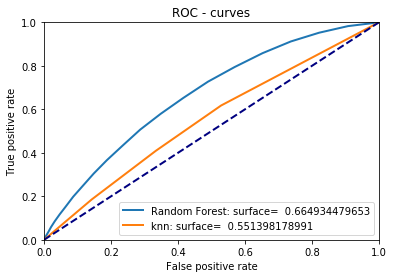

In [57]:
plt.figure()
for name in dico_roc.keys():
    label = name + ': surface=  ' + str(dico_roc[name][2])
    plt.plot(dico_roc[name][0], dico_roc[name][1], lw=2, label=label )
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC - curves')
plt.legend(loc="lower right")
plt.show()

## Tuning the hyperparameter of  Random Forest model

In [59]:
name = 'RF_tuned'

# give hyper-parameters to tun
param_grid = { 
    'n_estimators': [25, 100],
    'max_depth' : [3,5,7],
    'criterion' :['gini', 'entropy']}

# give the score to optimize. Here we choose accuracy
score = 'accuracy'

# Classifier (Here cv= number of folds in cross-validation process)
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring=score )

clf.fit(x_train, y_train)

# Show optimized hyperparamètres
print( "Best hyperparamètres are:")
print( clf.best_params_)

# Show the result of cross validation processsus 
print( "The result of cross validation :")
print("accuracy, mean, std, k_neighbors")
for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'],
                             clf.cv_results_['params'] ):
    print( "\t%s = %0.3f (+/-%0.03f) for %r" % (score, mean, std * 2, params ))
fpr, tpr, surface = roc_curve_plot(clf, name, x_test, y_test)
dico_roc[name] = (fpr, tpr, surface)

Best hyperparamètres are:
{'n_estimators': 100, 'criterion': 'gini', 'max_depth': 7}
The result of cross validation :
accuracy, mean, std, k_neighbors
	accuracy = 0.662 (+/-0.082) for {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3}
	accuracy = 0.670 (+/-0.079) for {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 3}
	accuracy = 0.710 (+/-0.111) for {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 5}
	accuracy = 0.712 (+/-0.106) for {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5}
	accuracy = 0.735 (+/-0.137) for {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 7}
	accuracy = 0.739 (+/-0.140) for {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 7}
	accuracy = 0.676 (+/-0.071) for {'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 3}
	accuracy = 0.674 (+/-0.086) for {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 3}
	accuracy = 0.700 (+/-0.101) for {'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 5}
	accuracy = 0.717

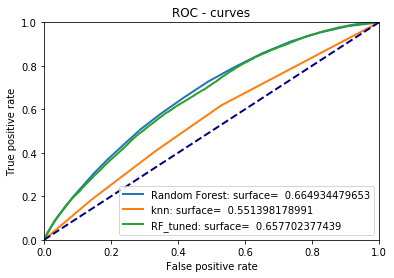

In [60]:
# plot the ROC curves
plt.figure()
for name in dico_roc.keys():
    label = name + ': surface=  ' + str(dico_roc[name][2])
    plt.plot(dico_roc[name][0], dico_roc[name][1], lw=2, label=label )
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC - curves')
plt.legend(loc="lower right")
plt.show()

The tuned Random Forest model gives slightly less surface of ROC curve. This is because we limited the max depth of tree to 7. Or, In default case, "The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples." as mentioned in description of Random Forest algorithm on sklearn library.

In [61]:
# Here, we'll show the result with max depth equal to7
clf = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=7, criterion='gini')

clf.fit(x_train, y_train)

print('=========================================================')

# test prediction
y_pred_test = clf.predict(x_test)    
        
print("Classifier name : ", name)

# test accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test accuracy = ", accuracy_test)
    
    
print("Confusion Matrix")
print('**************************')
print('--------------------------')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns=['pred_0', 'pred_1'], index=['0', '1']))
print('--------------------------')
    
    
print("Test classification report")
print('**************************')
print(classification_report(y_test, y_pred_test))
    
print('=========================================================')

Classifier name :  RF_tuned
Test accuracy =  0.71130017915
Confusion Matrix
**************************
--------------------------
   pred_0  pred_1
0  101976   27129
1   19121   11975
--------------------------
Test classification report
**************************
             precision    recall  f1-score   support

          0       0.84      0.79      0.82    129105
          1       0.31      0.39      0.34     31096

avg / total       0.74      0.71      0.72    160201

